## Exploring Sentiment Towards a 10-Year Minimum Occupation Period in Prime Location Housing (PLH) Model

On October 27th, the Ministry of National Development (MND) and the Housing Development Board (HDB) announced the new Prime Location Housing (PLH) model. This is the first model of its kind in Singapore and aims to help lower to middle-income families live in the city area. Before releasing this model, they gathered public feedback and carefully planned it.

To understand how people feel about the new PLH model, we will do the following:

Collect data from Reddit using PRAW (Python Reddit API Wrapper).
Process and clean the data (e.g., clean text, extract and convert emojis).
Conduct sentiment analysis using TextBlob.
Perform NLP analysis using NLTK (tokenization, POS-tagging, stemming, and removing stop words).
Before starting data collection and cleaning, we expect most comments to be positive because of the extensive public engagement and feedback that shaped the model.

However, it's important to note that the data from Reddit is not a proper sample size and doesn't represent the entire Singapore population. We cannot get information about users' age, gender, marital status, or financial status from Reddit, so these factors are not included in the analysis.

## 1. Loading Packages

In [1]:
# import praw
# from praw.models import MoreComments
import datetime
import pandas as pd
import numpy as np
import re
import pprint
pd.options.mode.chained_assignment = None

from textblob import TextBlob

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import tokenize
import spacy
#conda install -c conda-forge spacy-model-en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()
nltk.download('averaged_perceptron_tagger')

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns

import emoji

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/puttasathvik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/puttasathvik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/puttasathvik/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 2.Scraping Data from Reddit

We'll collect all top-level (parent) comments and their replies using Reddit's API. To keep track of which replies belong to which comments, we'll also collect the comment IDs, parent IDs, and usernames of the people who posted them. The usernames are important for the following reasons:

Deleted accounts with removed comments
Deleted accounts with unremoved comments
Bot accounts like RemindMeBot and sneakpeek_bot
When we clean the data, we'll need to remove these unwanted accounts while keeping the comments intact.

Note that comment.author returns a Reddit object. To get just the username, we need to use comment.author.name. We must check that comment.author is not None (to avoid deleted accounts), but since deleted accounts still have comments, we'll continue using comment.author.

Additionally, we'll store comments and Reddit user details separately.

In [2]:
# #create reddit instance and provide client_id, client_secret and user_agent
# #you will need a reddit account in order to access the API
# reddit = praw.Reddit(client_id='XXX', client_secret='XXX', user_agent='XXX')

# #crease submission variable where URL passed in as a parameter 
url = "https://www.reddit.com/r/singapore/comments/qgo2dz/new_prime_bto_owners_face_10_year_occupation/"
# # submission = reddit.submission(url=url)
# #extract relevant data using PRAW
# r_posts = []
# r_details = []
# # r_username = []

# submission.comments.replace_more(limit = 0)
# for comment in submission.comments.list():
#     r_posts.append(comment.body)
#     r_details.append([comment.id, comment.parent(), comment.author, comment.score, comment.created])
# #     if comment.author is not None:
# #         r_username.append(comment.author.name)

# #convert list into dataframe 
# df_comment = pd.DataFrame(r_posts,columns= ["comment"])   
# df_details = pd.DataFrame(r_details,columns=["comment_id", "parent_id", "username", "upvotes", "datetime"])

## 3. Data Cleaning and Processing 

The data is stored in two separate files: df_comments and df_details. We'll focus on cleaning the comments in df_comments. It's important to make sure that the number of rows stays the same before and after cleaning, so no data is lost.

Here are the steps to clean the data:

Remove links and link markups.
Remove double spaces that appear as "​".
Remove irrelevant comments (like deleted comments or those made by bots).
Remove duplicate comments (such as parent comments repeated in replies, like in WhatsApp).
Clean up text (fix contractions, typos, slang, emojis, etc.).

## 3a. Removing Duplicate Comments (parent comments in replies), Links, and Link Markups

For duplicate comments, the PRAW API doesn't remove parent comments in replies. To fix this, we need to split the comments using "\n\n" as a separator and then expand the nested list into individual rows. Duplicate parent comments start with ">", so we can replace these comments with an empty string ("") to keep the number of rows the same.

Here's an example:

">It will be located on two plots of land along Weld Road and Kelantan Road next to Jalan Besar MRT station, said the National Development Ministry and Housing Board in a joint statement on Wednesday (Oct 27).\n\nok so now we know they took away the rent-free Sungei Road flea market in 2017 and the open space carpark beside SLT for this. \n\n​\n\n>Besides an MRT station at their doorstep, future residents will also be within walking distance of Berseh Food Centre and Stamford Primary School"

After cleaning and processing, we can group and join the rows back together.








In [3]:
df_comment = pd.read_csv("/Users/puttasathvik/Downloads/TextBasedAnalysis/Final Project/comment.csv")
df_details = pd.read_csv("/Users/puttasathvik/Downloads/TextBasedAnalysis/Final Project/details.csv")

In [4]:
#check number of rows
len(df_comment)

358

In [5]:
#check for for any empty cells 
df_comment.isna().sum()

comment    0
dtype: int64

In [6]:
#split sentences by delimited "\n\n"
df_comment["comment"] = [item.split("\n\n") for item in df_comment.comment]

#explode nested list into individual rows 
df_comment = df_comment.explode("comment").rename_axis("index_name").reset_index()

#replace double space with empty string
df_comment["comment"] = df_comment.comment.str.replace("&#x200B;", "")

In [7]:
#check number of rows after exploding
len(df_comment)

580

In [8]:
#for replies with parent comments within, remove parent comment and retain replies  
#those are fields with string that start with ">"
#remove bullet points 
df_comment.loc[df_comment.comment.str.startswith(">")] = "/Users/puttasathvik/Downloads/TextBasedAnalysis/Final Project/comment.csv"
df_comment["comment"] = [i.strip() for i in df_comment.comment]
df_comment["comment"] = [re.sub(r"^[0-9]", " ", i) for i in df_comment.comment]

/var/folders/5g/277wtpf90l59q6v17xfw76h00000gn/T/ipykernel_24294/749234558.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '/Users/puttasathvik/Downloads/TextBasedAnalysis/Final Project/comment.csv' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_comment.loc[df_comment.comment.str.startswith(">")] = "/Users/puttasathvik/Downloads/TextBasedAnalysis/Final Project/comment.csv"


In [9]:
#see table of items with https links and markup links 
df_comment.loc[df_comment.comment.str.contains("https")]

,index_name,comment
36,19,The existing Stamford Primary School nearby ha...
56,20,---\n1.0.2 | [Source code](https://github.com/...
336,219,Yup - or they can decide not to get married [l...
503,322,https://www.ons.gov.uk/peoplepopulationandcomm...
509,325,https://www.iras.gov.sg/taxes/individual-incom...
516,329,I will be messaging you in 11 years on [**2032...
517,329,[**CLICK THIS LINK**](https://www.reddit.com/m...
518,329,^(Parent commenter can ) [^(delete this messag...
520,329,|[^(Info)](https://www.reddit.com/r/RemindMeBo...
529,335,https://www.reddit.com/r/singapore/comments/8n...


In [10]:
#do a temporary table to see the usernames for these comments 

df_temp_https = df_comment[df_comment.comment.str.contains("https")]
df_temp_details = df_details.reset_index()
df_temp = pd.merge(df_temp_https, df_temp_details, how = "inner", left_on = "index_name", right_on = "index")
df_temp

,index_name,comment,index,comment_id,parent_id,username,upvotes,datetime
0,19,The existing Stamford Primary School nearby ha...,19,hi7lm8f,qgo2dz,jmzyn,24,1.635310e+09
1,20,---\n1.0.2 | [Source code](https://github.com/...,20,hi7gzzk,qgo2dz,sneakpeek_bot,5,1.635307e+09
2,219,Yup - or they can decide not to get married [l...,219,hi83v1u,hi7pfvf,sitsthewind,2,1.635324e+09
3,322,https://www.ons.gov.uk/peoplepopulationandcomm...,322,hi92uhw,hi80uyy,xvdrk,1,1.635345e+09
4,325,https://www.iras.gov.sg/taxes/individual-incom...,325,hi7z0ep,hi7xn9n,GoodBoysThinkAlike,30,1.635320e+09
5,329,I will be messaging you in 11 years on [**2032...,329,hi7qeza,hi7qcsv,RemindMeBot,2,1.635313e+09
6,329,[**CLICK THIS LINK**](https://www.reddit.com/m...,329,hi7qeza,hi7qcsv,RemindMeBot,2,1.635313e+09
7,329,^(Parent commenter can ) [^(delete this messag...,329,hi7qeza,hi7qcsv,RemindMeBot,2,1.635313e+09
8,329,|[^(Info)](https://www.reddit.com/r/RemindMeBo...,329,hi7qeza,hi7qcsv,RemindMeBot,2,1.635313e+09
9,335,https://www.reddit.com/r/singapore/comments/8n...,335,hi7y3w6,hi7xoes,yewjrn,5,1.635319e+09


In [11]:
# define function to remove both links and markup links 
# also remove \' from dont\'t
def remove_https(item):
    #remove https links
    item_1 = re.sub(r"[(+*)]\S*https?:\S*[(+*)]", "", item)
    #remove https links with no brackets
    item_2 = re.sub('http://\S+|https://\S+', " ", item_1)
    #remove link markups []
    #note that this will also remove comment fields with ["Delete"] 
    item_3 = re.sub(r"[\(\[].*?[\)\]]", " ", item_2)
#     #remove \ in don\'t
#     item_4 = re.sub("[\"\']", "'", item_3)
    return item_3

df_comment["comment"] = [remove_https(x) for x in df_comment.comment]

In [12]:
#check the temporary table to see if links/ markuplinks/ \' 
#all links has been removed
#unecessary comments (highlighted in yellow) can be removed later by filtering out unecessary usernames
df_temp["comment"] = [remove_https(x) for x in df_temp.comment]
df_temp.style.apply(lambda x: ['background: lightyellow' if x.username == "RemindMeBot" \
                               or x.username =="sneakpeek_bot" else '' for i in x], axis=1)

,index_name,comment,index,comment_id,parent_id,username,upvotes,datetime
0,19,The existing Stamford Primary School nearby has already been slated to merge to Farrer Park Primary School campus in . Someone obviously didn't do homework!,19,hi7lm8f,qgo2dz,jmzyn,24,1635310102.000000
1,20,--- 1.0.2 | |,20,hi7gzzk,qgo2dz,sneakpeek_bot,5,1635307441.000000
2,219,Yup - or they can decide not to get married .,219,hi83v1u,hi7pfvf,sitsthewind,2,1635324215.000000
3,322,,322,hi92uhw,hi80uyy,xvdrk,1,1635345487.000000
4,325,,325,hi7z0ep,hi7xn9n,GoodBoysThinkAlike,30,1635320022.000000
5,329,I will be messaging you in 11 years on [**2032-10-27 05:40:25 UTC to remind you of [**this link,329,hi7qeza,hi7qcsv,RemindMeBot,2,1635313267.000000
6,329,[**CLICK THIS LINK to send a PM to also be reminded and to reduce spam.,329,hi7qeza,hi7qcsv,RemindMeBot,2,1635313267.000000
7,329,^ [^(delete this message to hide from others.,329,hi7qeza,hi7qcsv,RemindMeBot,2,1635313267.000000
8,329,|[^Your Reminders| |-|-|-|-|,329,hi7qeza,hi7qcsv,RemindMeBot,2,1635313267.000000
9,335,,335,hi7y3w6,hi7xoes,yewjrn,5,1635319252.000000


In [13]:
#check number of rows
len(df_comment)

580

In [14]:
#implode and remove column index_name
df_comment_1 = df_comment.groupby("index_name")["comment"].apply(lambda x: " ".join(x)).reset_index().drop("index_name", axis = 1)

In [15]:
#check that total columns are still the same before explode
#seems that there is additional row 
len(df_comment_1)

359

In [16]:
#last row is the additional empty row
df_comment_1.tail()

,comment
354,What do you think?
355,By your logic rich people shouldn't pay taxes ...
356,"Well, their future babies tax dollars are gonn..."
357,No. Statistics matter when drawing a conclusio...
358,/Users/puttasathvik/Downloads/TextBasedAnalysi...


In [17]:
#remove the last row by slicing 
df_comment_1 = df_comment_1[:358]

## 3b. Removing Deleted/Bot User Accounts and Empty Comments

After tidying up df_comment, we can combine it with df_details to further clean the data. This process will involve removing unwanted usernames (like bot accounts) and any empty comments. During the cleanup of df_comment, we made sure the number of rows stayed the same. This allows us to safely merge the two datasets because their indexes will match perfectly.

In [18]:
#concatenate both datasets with same index 
df = pd.concat([df_comment_1, df_details], axis = 1)
df

,comment,comment_id,parent_id,username,upvotes,datetime
0,Honestly pretty happy with this - getting a pr...,hi7j3kg,qgo2dz,eastsidegoondu,192,1.635309e+09
1,Key part here is that it's also unavailable fo...,hi7hcbh,qgo2dz,MacWithoutCheese,505,1.635308e+09
2,Great. We should stop treating public housing ...,hi7i2xs,qgo2dz,pewsg,314,1.635308e+09
3,This is good news for those who really needs a...,hi7ieqf,qgo2dz,PossibleConsistent77,97,1.635308e+09
4,Never see Noobhdbbuyer commenting if he's happ...,hi7mdia,qgo2dz,Exofanjongdae,60,1.635311e+09
...,...,...,...,...,...,...
353,I dare you to write to Straits Times forum pro...,hi84isq,hi81api,sitsthewind,4,1.635325e+09
354,What do you think?,hi81lym,hi81api,loveforlandlords,-1,1.635322e+09
355,By your logic rich people shouldn't pay taxes ...,hi88k5u,hi88fn0,loveforlandlords,4,1.635328e+09
356,"Well, their future babies tax dollars are gonn...",hi8mfr1,hi88fn0,ikanjonnies,3,1.635338e+09


In [19]:
#before we have replaced comments with empty string 
#see how many rows there are 
len(df[df.comment == " "])

10

In [20]:
df[df.comment == " "]

,comment,comment_id,parent_id,username,upvotes,datetime
52,,hi7pcje,qgo2dz,NaN,-6,1.635313e+09
78,,hi7q2m5,hi7i9ej,NaN,17,1.635313e+09
156,,hi7xw5v,hi7tdh4,NaN,10,1.635319e+09
186,,hi7khkd,hi7k5ie,NaN,32,1.635309e+09
198,,hi7oufu,hi7mxzs,NaN,1,1.635312e+09
228,,hi7lomx,hi7lgl9,NaN,7,1.635310e+09
264,,hi7z5qj,hi7ys7b,NaN,5,1.635320e+09
282,,hi89j0o,hi8953v,NaN,9,1.635329e+09
293,,hi7ptfn,hi7p79j,NaN,1,1.635313e+09
335,,hi7y3w6,hi7xoes,yewjrn,5,1.635319e+09


In [21]:
#remove rows with empty field under comment attribute
#removed 10 rows, 348 rows
df = df[df.comment != " "]

In [22]:
#username is none == useraccount that has been deleted
#seems like deleted accounts has comments that is not removed
#we will leave these accounts alone 
df[df.username.isna()]

,comment,comment_id,parent_id,username,upvotes,datetime
21,Hear me out. What if they gave out higher subs...,hi81l0r,qgo2dz,NaN,4,1.635322e+09
44,Oh no. how am I going to be a millionaire now?,hi7otkz,qgo2dz,NaN,1,1.635312e+09


In [23]:
df[(df.username == "RemindMeBot") | (df.username == "sneakpeek_bot")]

,comment,comment_id,parent_id,username,upvotes,datetime
20,---\n1.0.2 | |,hi7gzzk,qgo2dz,sneakpeek_bot,5,1.635307e+09
329,I will be messaging you in 11 years on [**2032...,hi7qeza,hi7qcsv,RemindMeBot,2,1.635313e+09


In [24]:
#remove comments by bots "RemindMeBot", "sneakpeek_bot"
#reset index so that it is running 
#removeed 2 rows, resulting dataframe will have 346 rows
df = df[(df.username != "RemindMeBot") & (df.username != "sneakpeek_bot")].reset_index(drop = True)

In [25]:
df.head()

,comment,comment_id,parent_id,username,upvotes,datetime
0,Honestly pretty happy with this - getting a pr...,hi7j3kg,qgo2dz,eastsidegoondu,192,1.635309e+09
1,Key part here is that it's also unavailable fo...,hi7hcbh,qgo2dz,MacWithoutCheese,505,1.635308e+09
2,Great. We should stop treating public housing ...,hi7i2xs,qgo2dz,pewsg,314,1.635308e+09
3,This is good news for those who really needs a...,hi7ieqf,qgo2dz,PossibleConsistent77,97,1.635308e+09
4,Never see Noobhdbbuyer commenting if he's happ...,hi7mdia,qgo2dz,Exofanjongdae,60,1.635311e+09


In [26]:
len(df)

346

## 3c. Text Clean-Up

Text clean-up is part of getting data ready. Online comments are often messy and have issues like:

1. Typos

2. Contractions (don’t, can’t, shouldn’t)

3. Abbreviations (govt for government, info for information)

4. Internet slang (irl, fyi)

5. Creole languages (like Singlish in Singapore)

We need to fix these problems to turn the text into proper English without slang or grammar mistakes. Also, since we will use TextBlob for analyzing feelings in the text, we need to change emojis into words or phrases because TextBlob only works with text.








In [27]:
#ensure that comment attribute is of correct data type
df["comment"] = df.comment.astype("str")
df["comment"] = [item.lower() for item in df.comment]

#remove apostrophe at the beginning and end of each word (e.g. 'like, 'this, or', this')
df["comment"] = [re.sub(r"(\B'\b)|(\b'\B)", ' ', item) for item in df.comment]
df["comment"] = [re.sub(r'…', ' ', item) for item in df.comment]
df["comment"] = [item.replace('\\',' ') for item in df.comment]
df["comment"] = [item.replace('/',' ') for item in df.comment]

In [28]:
#TEST
#have a overview/ general sensing of types of contractions we have 
#create a temp list of tokenized sentences 
df_token_temp = [item.split() for item in df["comment"]]
df_token_temp = [i for word in df_token_temp for i in word]
df_contraction_temp = [re.findall("(?=\S*['-])([a-zA-Z'-]+)", i) for i in df_token_temp]
df_contraction_temp_1 = [i for item in df_contraction_temp if item != [] for i in item]
df_contraction_temp_2 = [i for n, i in enumerate(df_contraction_temp_1) if i not in df_contraction_temp_1[:n]]
print(df_contraction_temp_2)

['-', "don't", "it's", "he's", 'no-mop', '-year', "i'm", 'rent-free', "didn't", "doesn't", "hasn't", "we'll", 'instrument', '--especially', '-it', 'generation', '--like', "isn't", 'confidence', '-one', "that's", 'non-nuclear', "they'll", "what's", "won't", "they're", 'non-married', "people's", "can't", "there'll", 'split-society-haves-vs-have-nots', 'hdb-dwellers', "wouldn't", "plh's", 'non-prime', 'win-win', 'so-called', "other's", "they'd", "shouldn't", 'senior-friendly', "let's", 'knock-on', "you're", "it'll", "friend's", "wife's", 'prime-ish', 'in-between', '-room', 'non-mature', '-rooms', "there's", 'family-building', "worker's", "i'll", 'non-matured', 'pap-land', 'lgbtq-friendly', 'single-friendly', 'sub-', 'dual-income', 'en-bloc', "we're", 'family-only', "couple's", "government's", 'self-employed', "haven't", 'non-flippers', "i've", "kpkb'ing", "aren't", "sg's", 'pre-marriage', "you'll", "govenment's", "she's", 'non-high', 'non-rental', 'higher-paid', 'lower-paid', 'covid-']


In [29]:
#define a function to clean up these contractions 
#for \'s such as he's, she's we will just replace with he and she as is is a stop word and will be removed 
def decontract(phrase):  
    phrase = re.sub(r"can\'t", "cannot", phrase)
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'s", "", phrase)
    #"kpkb'ing"
    phrase = re.sub(r"\'ing", "", phrase)
    
    phrase = re.sub(r"can’t", "cannot", phrase)
    phrase = re.sub(r"won’t", "will not", phrase)
    phrase = re.sub(r"let’s", "let us", phrase)
    phrase = re.sub(r"n’t", " not", phrase)
    phrase = re.sub(r"’m", " am", phrase)
    phrase = re.sub(r"’ll", " will", phrase)
    phrase = re.sub(r"’re", " are", phrase)
    phrase = re.sub(r"’d", " would", phrase)
    phrase = re.sub(r"’ve", " have", phrase)
    phrase = re.sub(r"’s", "", phrase)
    #"kpkb'ing"
    phrase = re.sub(r"’ing", "", phrase)
    return phrase

In [30]:
#TEST
#test it on df_contraction_temp_2
df_contraction_temp_3 = [decontract(i) for i in df_contraction_temp_2]
print(df_contraction_temp_3)

['-', 'do not', 'it', 'he', 'no-mop', '-year', 'i am', 'rent-free', 'did not', 'does not', 'has not', 'we will', 'instrument', '--especially', '-it', 'generation', '--like', 'is not', 'confidence', '-one', 'that', 'non-nuclear', 'they will', 'what', 'will not', 'they are', 'non-married', 'people', 'cannot', 'there will', 'split-society-haves-vs-have-nots', 'hdb-dwellers', 'would not', 'plh', 'non-prime', 'win-win', 'so-called', 'other', 'they would', 'should not', 'senior-friendly', 'let us', 'knock-on', 'you are', 'it will', 'friend', 'wife', 'prime-ish', 'in-between', '-room', 'non-mature', '-rooms', 'there', 'family-building', 'worker', 'i will', 'non-matured', 'pap-land', 'lgbtq-friendly', 'single-friendly', 'sub-', 'dual-income', 'en-bloc', 'we are', 'family-only', 'couple', 'government', 'self-employed', 'have not', 'non-flippers', 'i have', 'kpkb', 'are not', 'sg', 'pre-marriage', 'you will', 'govenment', 'she', 'non-high', 'non-rental', 'higher-paid', 'lower-paid', 'covid-']


In [31]:
#decontract words in dataframe
df["comment"] = [decontract(i) for i in df.comment]

In [32]:
#define a function to find all emojis
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])

In [33]:
import emoji

def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.EMOJI_DATA)
# Assuming df is your DataFrame and 'comment' is the column with the text
emoji_lst = [extract_emojis(i) for i in df['comment'].tolist()]
emoji_lst = list(filter(None, emoji_lst))
emoji_lst

['😢', '🤨', '🙄', '😂']

In [34]:
#define a function that converts emojis to words/ phrase
def convert_emoji(phrase):
    phrase = re.sub(r"😢", " sad ", phrase)
    phrase = re.sub(r"🤨", " not confident ", phrase)
    phrase = re.sub(r"🙄", " annoying ",  phrase)
    phrase = re.sub(r"😂", " laugh ", phrase)
    return phrase

df["comment"] = [convert_emoji(i) for i in df.comment]


In [35]:
#define a function that converts all typos
def clean_typo(phrase):
    phrase = re.sub(r"-ish", "", phrase)
    phrase = re.sub(r"rrcent", "recent", phrase)
    phrase = re.sub(r"govenment", " government ", phrase)
    phrase = re.sub(r"diffit", "definitely", phrase)
    phrase = re.sub(r"overexxagearting", "overexaggerate", phrase)
    phrase = re.sub(r"en-bloc", "enbloc", phrase)
    phrase = re.sub(r" dnt ", "do not", phrase)
    phrase = re.sub(r" underdeclared ", " under declare ", phrase)
    phrase = re.sub(r" lgbt ", " lgbtq ", phrase)
    phrase = re.sub(r" 9wn ", " own ", phrase)
    phrase = re.sub(r" rocher ", " rochor ", phrase)
    phrase = re.sub(r" pinnacle ", " duxton ", phrase)
    phrase = re.sub(r" cdb ", " cbd ", phrase)
    phrase = re.sub(r" hivemind ", " hive mind ", phrase)
    phrase = re.sub(r" claw back ", " clawback ", phrase)
    phrase = re.sub(r" discludes ", " excludes ", phrase)
    phrase = re.sub(r" hugeee ", " huge ", phrase)
    phrase = re.sub(r" birthrate ", " birth rate ", phrase)
    phrase = re.sub(r" oligations ", " obligations ", phrase)
    phrase = re.sub(r" wayyy ", " way ", phrase)
    phrase = re.sub(r" plhs ", " plh ", phrase)
    phrase = re.sub(r" noobhdbbuyer ", " noob hdb buyer ", phrase)
    return phrase
    
df["comment"] = [clean_typo(i) for i in df.comment]

In [36]:
#define a function to convert all short-forms/ short terms 
def clean_short(phrase):
    phrase = re.sub(r"fyi", "for your information", phrase)
    phrase = re.sub(r"tbh", "to be honest", phrase)
    phrase = re.sub(r" esp ", " especially ", phrase)
    phrase = re.sub(r" info ", "information", phrase)
    phrase = re.sub(r"gonna", "going to", phrase)
    phrase = re.sub(r"stats", "statistics", phrase)
    phrase = re.sub(r"rm ", " room ", phrase)
    phrase = phrase.replace("i.e.", " ")
    phrase = re.sub(r"idk", "i do not know", phrase)
    phrase = re.sub(r"haha", "laugh", phrase)
    phrase = re.sub(r"yr", " year", phrase)
    phrase = re.sub(r" sg ", " singapore ", phrase)
    phrase = re.sub(r" mil ", " million ", phrase)
    phrase = re.sub(r" =", " same ", phrase)
    phrase = re.sub(r" msr. ", " mortage serving ratio ", phrase)
    phrase = re.sub(r" eip ", " ethnic integration policy ", phrase)
    phrase = re.sub(r" g ", " government ", phrase)
    phrase = re.sub(r"^imo ", " in my opinion ", phrase)
    phrase = re.sub(r" pp ", " private property ", phrase)
    phrase = re.sub(r" grad ", " graduate ", phrase)
    phrase = re.sub(r" ns ", " national service ", phrase)
    phrase = re.sub(r" bc ", " because ", phrase)
    phrase = re.sub(r" u ", " you ", phrase)
    phrase = re.sub(r" ur ", " your ", phrase)
    phrase = re.sub(r"^yo ", " year ", phrase)
    phrase = re.sub(r" vs ", " versus ", phrase)
    phrase = re.sub(r" irl ", " in reality ", phrase)
    phrase = re.sub(r" tfr ", " total fertility rate ", phrase)
    phrase = re.sub(r" fk ", " fuck ", phrase)
    phrase = re.sub(r" fked ", " fuck ", phrase)
    phrase = re.sub(r" fucked ", " fuck ", phrase)
    phrase = re.sub(r".  um.", " cynical. ", phrase)
    phrase = re.sub(r" pre-", " before ", phrase)
    phrase = re.sub(r" ed ", " education ", phrase)
    return phrase

In [37]:
#define a function that converts singlish
def singlish_clean(phrase):
    phrase = re.sub(r"yup", " yes", phrase)
    phrase = re.sub(r" yah ", " yes", phrase)
    phrase = re.sub(r"yeah", "yes", phrase)
    phrase = re.sub(r" ya ", "  yes", phrase)
    phrase = re.sub(r"song ah", "good", phrase)
    phrase = re.sub(r" lah", " ", phrase)
    phrase = re.sub(r"hurray", "congratulation", phrase)
    phrase = re.sub(r"^um", "unsure", phrase)
    phrase = re.sub(r" sian ", " tired of ", phrase)
    phrase = re.sub(r" eh", " ", phrase)
    phrase = re.sub(r" hentak kaki ", " stagnant ", phrase)
    phrase = re.sub(r" ulu ", " remote ", phrase)
    phrase = re.sub(r" kpkb ", " complain ", phrase)
    phrase = re.sub(r" leh.", " .", phrase)
    phrase = re.sub(r"sinkies", " rude ", phrase)
    phrase = re.sub(r"sinkie", " rude ", phrase)
    phrase = re.sub(r"shitty", "shit", phrase)
    return phrase

df["comment"] = [singlish_clean(i) for i in df.comment]

In [38]:
def others_clean(phrase):
    phrase = re.sub(r" govt ", " government ", phrase)
    phrase = re.sub(r"14 000", "14k", phrase)
    phrase = re.sub(r"14000", "14k", phrase)
    phrase = re.sub(r"14,000", "14k", phrase)
    phrase = re.sub(r"flipper", "flip ", phrase)
    phrase = re.sub(r"flip s", "flip", phrase)
    phrase = re.sub(r"flipping", "flip ", phrase)
    phrase = re.sub(r"hdbs", "hdb", phrase)
    phrase = re.sub(r"dont", "do not", phrase)
    phrase = re.sub(r"cant", "cannot", phrase)
    phrase = re.sub(r"shouldnt", "should not", phrase)
    phrase = re.sub(r"condominiums", "condo ", phrase)
    phrase = re.sub(r"condominium", "condo ", phrase)
    phrase = re.sub(r"btos", "bto", phrase)
    phrase = re.sub(r"non-", "not ", phrase)
    phrase = re.sub(r" x+ ", " ", phrase)
    phrase = re.sub(r" ccr or ", " ", phrase)
    phrase = re.sub(r" its ", " it ", phrase)
    return phrase

df["comment"] = [others_clean(i) for i in df.comment]

In [39]:
df.head()

,comment,comment_id,parent_id,username,upvotes,datetime
0,honestly pretty happy with this - getting a pr...,hi7j3kg,qgo2dz,eastsidegoondu,192,1.635309e+09
1,key part here is that it also unavailable for ...,hi7hcbh,qgo2dz,MacWithoutCheese,505,1.635308e+09
2,great. we should stop treating public housing ...,hi7i2xs,qgo2dz,pewsg,314,1.635308e+09
3,this is good news for those who really needs a...,hi7ieqf,qgo2dz,PossibleConsistent77,97,1.635308e+09
4,never see noob hdb buyer commenting if he happ...,hi7mdia,qgo2dz,Exofanjongdae,60,1.635311e+09


## 4. Extracting Sentiments using Text Blob

TextBlob is a Python library used for Natural Language Processing that allows us to determine the polarity and subjectivity of a given sentence. The polarity score ranges between -1 and 1, where -1 indicates a highly negative sentiment and 1 indicates a highly positive sentiment. The subjectivity score ranges from 0 to 1, with 0 representing objective or factual content and 1 representing subjective content.

In our approach, we will analyze sentiment on a per-sentence basis rather than per comment.

Sentences will be classified as follows:

Negative: polarity < 0
Positive: polarity > 0
Neutral: polarity = 0

In [40]:
df_sentiment = df
df_sentiment.head()

,comment,comment_id,parent_id,username,upvotes,datetime
0,honestly pretty happy with this - getting a pr...,hi7j3kg,qgo2dz,eastsidegoondu,192,1.635309e+09
1,key part here is that it also unavailable for ...,hi7hcbh,qgo2dz,MacWithoutCheese,505,1.635308e+09
2,great. we should stop treating public housing ...,hi7i2xs,qgo2dz,pewsg,314,1.635308e+09
3,this is good news for those who really needs a...,hi7ieqf,qgo2dz,PossibleConsistent77,97,1.635308e+09
4,never see noob hdb buyer commenting if he happ...,hi7mdia,qgo2dz,Exofanjongdae,60,1.635311e+09


In [41]:
#separate each comment into invididual sentences
df_sentiment["comment"] = [tokenize.sent_tokenize(item) for item in df_sentiment.comment]

In [42]:
#split each sentence into individual rows
df_sentiment_1 = df_sentiment.explode("comment").reset_index(drop = True)

In [43]:
df_sentiment_1.head()

,comment,comment_id,parent_id,username,upvotes,datetime
0,honestly pretty happy with this - getting a pr...,hi7j3kg,qgo2dz,eastsidegoondu,192,1.635309e+09
1,though i hope for your sakes you do not get sa...,hi7j3kg,qgo2dz,eastsidegoondu,192,1.635309e+09
2,key part here is that it also unavailable for ...,hi7hcbh,qgo2dz,MacWithoutCheese,505,1.635308e+09
3,and also the resale of the flat being be less ...,hi7hcbh,qgo2dz,MacWithoutCheese,505,1.635308e+09
4,quite stringent and seems like exactly what ev...,hi7hcbh,qgo2dz,MacWithoutCheese,505,1.635308e+09


In [44]:
#define a function to obtain get polariy and subjectivity

def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity 
    sentiment_subjectivity = blob.sentiment.subjectivity 
    if sentiment_polarity > 0:
        sentiment_label = "positive"
    elif sentiment_polarity < 0:
        sentiment_label = "negative"
    else:
        sentiment_label = "neutral"
    #store result in a dictionary
    result = {"polarity": sentiment_polarity, 
             "subjectivity": sentiment_subjectivity,
             "sentiment": sentiment_label}
    return result    

In [45]:
#apply function and create new column to store result
df_sentiment_1["sentiment_result"] = df_sentiment_1.comment.apply(get_sentiment)

In [46]:
#split result (stored as dictionary) into individual key columns 
sentiment = pd.json_normalize(df_sentiment_1["sentiment_result"])

In [47]:
#concatenate both dataframe together horizontally
df_1 = pd.concat([df_sentiment_1,sentiment], axis = 1)
df_1.head()

,comment,comment_id,parent_id,username,upvotes,datetime,sentiment_result,polarity,subjectivity,sentiment
0,honestly pretty happy with this - getting a pr...,hi7j3kg,qgo2dz,eastsidegoondu,192,1.635309e+09,"{'polarity': 0.525, 'subjectivity': 1.0, 'sent...",0.525000,1.000000,positive
1,though i hope for your sakes you do not get sa...,hi7j3kg,qgo2dz,eastsidegoondu,192,1.635309e+09,"{'polarity': 0.18333333333333335, 'subjectivit...",0.183333,0.633333,positive
2,key part here is that it also unavailable for ...,hi7hcbh,qgo2dz,MacWithoutCheese,505,1.635308e+09,"{'polarity': 0.0, 'subjectivity': 1.0, 'sentim...",0.000000,1.000000,neutral
3,and also the resale of the flat being be less ...,hi7hcbh,qgo2dz,MacWithoutCheese,505,1.635308e+09,"{'polarity': -0.09583333333333333, 'subjectivi...",-0.095833,0.095833,negative
4,quite stringent and seems like exactly what ev...,hi7hcbh,qgo2dz,MacWithoutCheese,505,1.635308e+09,"{'polarity': 0.25, 'subjectivity': 0.25, 'sent...",0.250000,0.250000,positive


## 4a. Sentiments, Polarity and Subjectivity Analysis

We are expecting most sentences to have a positive sentiment. This is true, however, the number of positive and neutral sentiment sentences are almost similar, with positive at 44% and neutral at 38%. This mean majority of the redditors either feel that the PLH model is a positive model to be rolled out or are sitting on the fence about this new model.

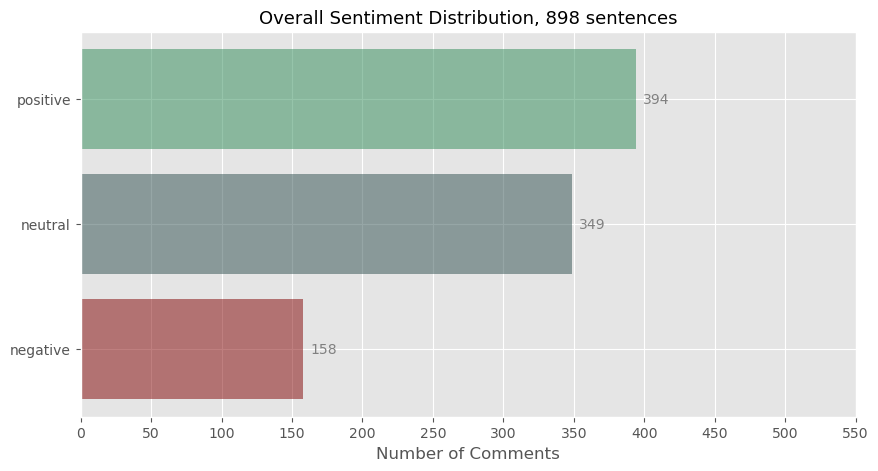

In [48]:
plt.style.use("ggplot")

positive = len(df_1[df_1.sentiment == "positive"])
negative = len(df_1[df_1.sentiment == "negative"])
neutral = len(df_1[df_1.sentiment == "neutral"])

sentiment = [positive, neutral, negative]
sentiment_cat = ["positive", "neutral", "negative"]

sentiment.reverse()
sentiment_cat.reverse()

fig, ax = plt.subplots(figsize=(10,5))

palette = ["maroon", "darkslategrey", "seagreen"]

hbars = plt.barh(sentiment_cat, sentiment, color = palette, alpha = 0.5)

ax.bar_label(hbars, fmt='%.0f', color = "grey", padding = 5)

plt.xticks(np.arange(0,560,50).tolist())

plt.xlabel("Number of Comments")
plt.title("Overall Sentiment Distribution, 898 sentences", size = 13)
plt.show()

Redditor comments are recorded exclusively on October 27th and 28th, 2021. The comment volume on October 28th, 2021, is minimal, making it more meaningful to analyze the hourly comment distribution for October 27th, 2021, instead.

In [49]:
#converting date to appropriate dtypes
df_1["datetime"] = pd.to_datetime(df_1.datetime, unit = "s")
df_1["date"] = df_1["datetime"].dt.date
df_1["hour"] = df_1["datetime"].dt.hour

In [50]:
df_date = df_1.groupby(["date", "sentiment"])["comment"].count().reset_index(name = "total_comment")
df_date.style.apply(lambda x: ['background: lightyellow' if x.total_comment < 40 \
                               else '' for i in x], axis=1)

,date,sentiment,total_comment
0,2021-10-27,negative,151
1,2021-10-27,neutral,324
2,2021-10-27,positive,379
3,2021-10-28,negative,7
4,2021-10-28,neutral,25
5,2021-10-28,positive,15


As anticipated, the volume of comments reaches its highest point at 5 a.m., then gradually declines throughout the day as the topic on PLH loses traction. Both positive and negative sentiment comments follow a similar pattern. In contrast, neutral sentiment comments diverge from this trend, displaying an inverse relationship to positive and negative sentiment comments as the day progresses.

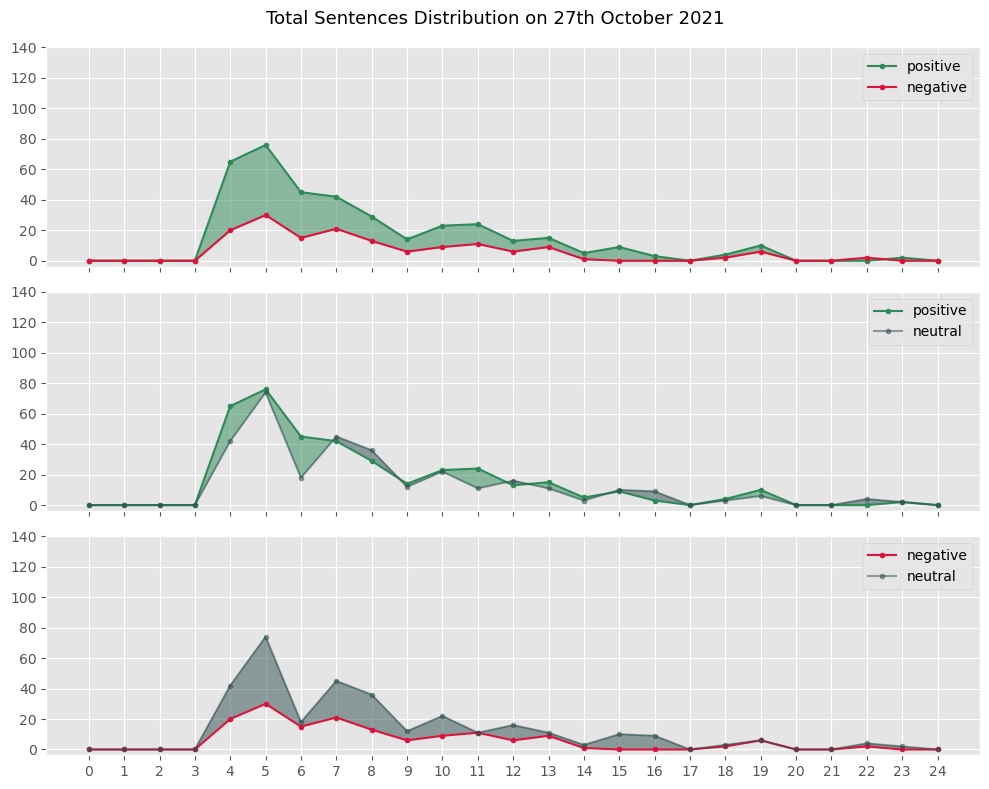

In [51]:
#create dataframe of all dates and time
a = np.arange(0,25,1).tolist()
df_total_hour = pd.DataFrame(a, columns = ["hour"])
df_total_date = pd.DataFrame([datetime.date(2021, 10, 27), datetime.date(2021, 10, 28)], columns = ["date"])
df_total_hour_date = pd.merge(df_total_date, df_total_hour, how = "cross")

#positive
positive = df_1[df_1.sentiment == "positive"]
positive_1 = pd.merge(positive, df_total_hour_date, how = "outer", on = ["date", "hour"])
positive_date = positive_1.groupby(["date", "hour"])["comment"].count().reset_index(name = "total_comment")
positive_date27 = positive_date[positive_date.date == datetime.date(2021, 10, 27)]

#negative
negative = df_1[df_1.sentiment == "negative"]
negative_1 = pd.merge(negative, df_total_hour_date, how = "outer", on = ["date", "hour"])
negative_date = negative_1.groupby(["date", "hour"])["comment"].count().reset_index(name = "total_comment")
negative_date27 = negative_date[negative_date.date == datetime.date(2021, 10, 27)]

#neutral
neutral = df_1[df_1.sentiment == "neutral"]
neutral_1 = pd.merge(neutral, df_total_hour_date, how = "outer", on = ["date", "hour"])
neutral_date = neutral_1.groupby(["date", "hour"])["comment"].count().reset_index(name = "total_comment")
neutral_date27 = neutral_date[neutral_date.date == datetime.date(2021, 10, 27)]

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex = True, sharey = True, figsize=(10,8))

#ax1 positive and negative
ax1.plot(positive_date27.hour, positive_date27.total_comment, label = "positive", color = "seagreen", marker = "o", markersize = 3)
ax1.plot(negative_date27.hour, negative_date27.total_comment, label = "negative", color = "crimson", marker = "o", markersize = 3)
ax1.fill_between(positive_date27.hour, positive_date27.total_comment, negative_date27.total_comment, color = "seagreen",
                alpha = 0.5)

#ax2 positive and neutral
ax2.plot(positive_date27.hour, positive_date27.total_comment, label = "positive", color = "seagreen", marker = "o", markersize = 3)
ax2.plot(neutral_date27.hour, neutral_date27.total_comment, label = "neutral", color = "darkslategrey", alpha = 0.5, marker = "o", markersize = 3)
ax2.fill_between(positive_date27.hour, positive_date27.total_comment, neutral_date27.total_comment,
                 positive_date27.total_comment > neutral_date27.total_comment, interpolate = True, color = "seagreen",
                alpha = 0.5)
ax2.fill_between(positive_date27.hour, positive_date27.total_comment, neutral_date27.total_comment,
                 positive_date27.total_comment < neutral_date27.total_comment, interpolate = True, color = "darkslategrey",
                alpha = 0.5)

#ax3 neutral and negative
ax3.plot(negative_date27.hour, negative_date27.total_comment, label = "negative", color = "crimson",  marker = "o", markersize = 3)
ax3.plot(neutral_date27.hour, neutral_date27.total_comment, label = "neutral", color = "darkslategrey", alpha = 0.5,  marker = "o", markersize = 3)
ax3.fill_between(negative_date27.hour, negative_date27.total_comment, neutral_date27.total_comment,
                 negative_date27.total_comment > neutral_date27.total_comment, interpolate = True, color = "crimson",
                alpha = 0.5)
ax3.fill_between(negative_date27.hour, negative_date27.total_comment, neutral_date27.total_comment,
                 negative_date27.total_comment < neutral_date27.total_comment, interpolate = True, color = "darkslategrey",
                alpha = 0.5)


plt.xticks(np.arange(0,25,1).tolist())
plt.yticks(np.arange(0,150,20).tolist())

ax1.legend()
ax2.legend()
ax3.legend()
    
plt.legend()

# plt.plot(positive_date28.hour, positive_date28.total_comment)
plt.suptitle("Total Sentences Distribution on 27th October 2021", size = 13)
plt.tight_layout()
plt.show()

Overall, the sentiment tends to be positive on a per-sentence basis, with most positive remarks exhibiting a polarity around +0.25. In contrast, sentences expressing negative sentiment hover closer to zero. Referring to the earlier bar chart, despite the higher count of positive sentiment sentences, the overall average polarity is 0.0875. However, this figure is calculated per sentence, and to obtain a more comprehensive understanding, we need to consider the average polarity across all sentences within each comment.

In [52]:
#sentiment for each sentence
df_sentence_summary = df_1[["comment", "polarity", "subjectivity"]]
df_sentence_summary.describe().style.apply(lambda x: ['background: lightyellow' if x.polarity > 0.08 \
                                                     and x.polarity < 0.09 else '' for i in x], axis=1)

,polarity,subjectivity
count,901.000000,901.000000
mean,0.087135,0.353105
std,0.232180,0.308896
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.337500
75%,0.200000,0.554167
max,1.000000,1.000000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


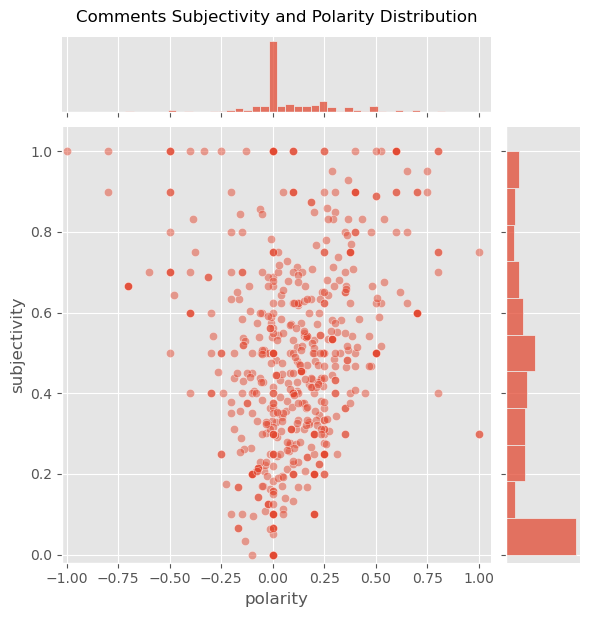

In [53]:
g = sns.jointplot(data = df_sentence_summary, 
           x = "polarity", y = "subjectivity",
        kind = "scatter", alpha = 0.5)

g.ax_marg_x.set_xlim(-1.02, 1.06)
g.ax_marg_y.set_ylim(-0.02, 1.06)

plt.suptitle("Comments Subjectivity and Polarity Distribution", y = 1.02, x = 0.47)
plt.show()

It is crucial to consider the tally of upvotes and downvotes, as these reflect the sentiments of Reddit users with similar viewpoints who did not leave comments. The average polarity value stands at 0.09, indicating a near-neutral tone. In general, the comments within this thread lean towards neutrality, albeit with a slight positive inclination.

## 5. Natural Language Processing (NLP)

To gain insights into the main topics that interest or concern redditors, it's essential to analyze the top 10 words. Moreover, understanding the part-of-speech and grammatical category of each word, whether it's a verb/action or noun, can provide further insights into potential topics. To extract the overall top 10 words, we'll follow these steps:

Tokenization: Break down each sentence into individual words.
POS-Tagging: Categorize each word into its grammatical category.
Stemming: Reduce each word to its root base (e.g., "people" becomes "peopl", "running" becomes "run").
Filtering Stop Words: Remove words that don't contribute additional meaning to the sentence (e.g., "me", "a", "the").

In [55]:
#selecting relevant attributes/ columns 
df_nlp = df_1[["comment", "sentiment"]]
df_nlp.head()

,comment,sentiment
0,honestly pretty happy with this - getting a pr...,positive
1,though i hope for your sakes you do not get sa...,positive
2,key part here is that it also unavailable for ...,neutral
3,and also the resale of the flat being be less ...,negative
4,quite stringent and seems like exactly what ev...,positive


In [56]:
#tokenize
df_nlp["comment"] = [word_tokenize(i) for i in df_nlp.comment]
df_nlp.head()

,comment,sentiment
0,"[honestly, pretty, happy, with, this, -, getti...",positive
1,"[though, i, hope, for, your, sakes, you, do, n...",positive
2,"[key, part, here, is, that, it, also, unavaila...",neutral
3,"[and, also, the, resale, of, the, flat, being,...",negative
4,"[quite, stringent, and, seems, like, exactly, ...",positive


In [58]:
#remove white/ blanks
df_nlp["comment"] = [[i for i in item if i != ""] for item in df_nlp.comment]
df_nlp.head()

,comment,sentiment
0,"[honestly, pretty, happy, with, this, -, getti...",positive
1,"[though, i, hope, for, your, sakes, you, do, n...",positive
2,"[key, part, here, is, that, it, also, unavaila...",neutral
3,"[and, also, the, resale, of, the, flat, being,...",negative
4,"[quite, stringent, and, seems, like, exactly, ...",positive


In [59]:
#process sequence of words using pos_tag()
df_nlp["comment"] = [nltk.pos_tag(item) for item in df_nlp.comment]
df_nlp.head()

,comment,sentiment
0,"[(honestly, RB), (pretty, RB), (happy, JJ), (w...",positive
1,"[(though, IN), (i, JJ), (hope, VBP), (for, IN)...",positive
2,"[(key, JJ), (part, NN), (here, RB), (is, VBZ),...",neutral
3,"[(and, CC), (also, RB), (the, DT), (resale, NN...",negative
4,"[(quite, RB), (stringent, JJ), (and, CC), (see...",positive


In [60]:
#stemming 
s_stemmer = SnowballStemmer(language='english')

df_nlp["comment_1"] = [[s_stemmer.stem(i[0]) for i in item] for item in df_nlp.comment]
df_nlp["comment_2"] = [[i[1] for i in item] for item in df_nlp.comment]

df_nlp["comment_1"] = [[re.sub(r"[^\w']", '', i) for i in item] for item in df_nlp.comment_1]
df_nlp["comment_2"] = [[re.sub(r"[^\w']", '', i) for i in item] for item in df_nlp.comment_2]
df_nlp.head()

,comment,sentiment,comment_1,comment_2
0,"[(honestly, RB), (pretty, RB), (happy, JJ), (w...",positive,"[honest, pretti, happi, with, this, , get, a, ...","[RB, RB, JJ, IN, DT, , VBG, DT, JJ, NN, NN, MD..."
1,"[(though, IN), (i, JJ), (hope, VBP), (for, IN)...",positive,"[though, i, hope, for, your, sake, you, do, no...","[IN, JJ, VBP, IN, PRP, NNS, PRP, VBP, RB, VB, ..."
2,"[(key, JJ), (part, NN), (here, RB), (is, VBZ),...",neutral,"[key, part, here, is, that, it, also, unavail,...","[JJ, NN, RB, VBZ, IN, PRP, RB, JJ, IN, JJ, RB,..."
3,"[(and, CC), (also, RB), (the, DT), (resale, NN...",negative,"[and, also, the, resal, of, the, flat, be, be,...","[CC, RB, DT, NN, IN, DT, JJ, VBG, VB, RBR, JJ, ]"
4,"[(quite, RB), (stringent, JJ), (and, CC), (see...",positive,"[quit, stringent, and, seem, like, exact, what...","[RB, JJ, CC, VBZ, IN, RB, WP, NN, RB, VBD, VBG..."


In [61]:
#separate each item into individual columns
df_nlp_1 = df_nlp[["sentiment", "comment_1", "comment_2"]].explode(["comment_1", "comment_2"]).explode(["comment_1", "comment_2"])
df_nlp_1.head()

,sentiment,comment_1,comment_2
0,positive,honest,RB
0,positive,pretti,RB
0,positive,happi,JJ
0,positive,with,IN
0,positive,this,DT


In [62]:
#remove all stop words 
stop_words_lst = list(nlp.Defaults.stop_words)
df_nlp_1 = df_nlp_1[~df_nlp_1.comment_1.isin(stop_words_lst)]

## 5a. Top 10 Most Occuring Word

In [63]:
#grouping and counting total number of occurance for each word 
df_nlp_2 = df_nlp_1[df_nlp_1.comment_1 != ""]

df_nlp_2 = df_nlp_2.groupby(["sentiment","comment_1", "comment_2"])["comment_1"].count().reset_index(name = "total_number")
df_nlp_2.sort_values(["sentiment", "total_number"], ascending = [False, False], inplace = True)

df_nlp_2.head()

,sentiment,comment_1,comment_2,total_number
2678,positive,peopl,NNS,55
2215,positive,flat,NNS,44
2334,positive,hous,NN,35
2266,positive,good,JJ,31
2301,positive,hdb,NN,31


In [64]:
#select top 10 words from each sentiment category 
df_nlp_15 = df_nlp_2.groupby("sentiment").head(10)
df_nlp_15.reset_index(inplace = True)
df_nlp_15["comment_1_2"] = df_nlp_15["comment_1"] + " - " + df_nlp_15["comment_2"]
df_nlp_15.head()

,index,sentiment,comment_1,comment_2,total_number,comment_1_2
0,2678,positive,peopl,NNS,55,peopl - NNS
1,2215,positive,flat,NNS,44,flat - NNS
2,2334,positive,hous,NN,35,hous - NN
3,2266,positive,good,JJ,31,good - JJ
4,2301,positive,hdb,NN,31,hdb - NN


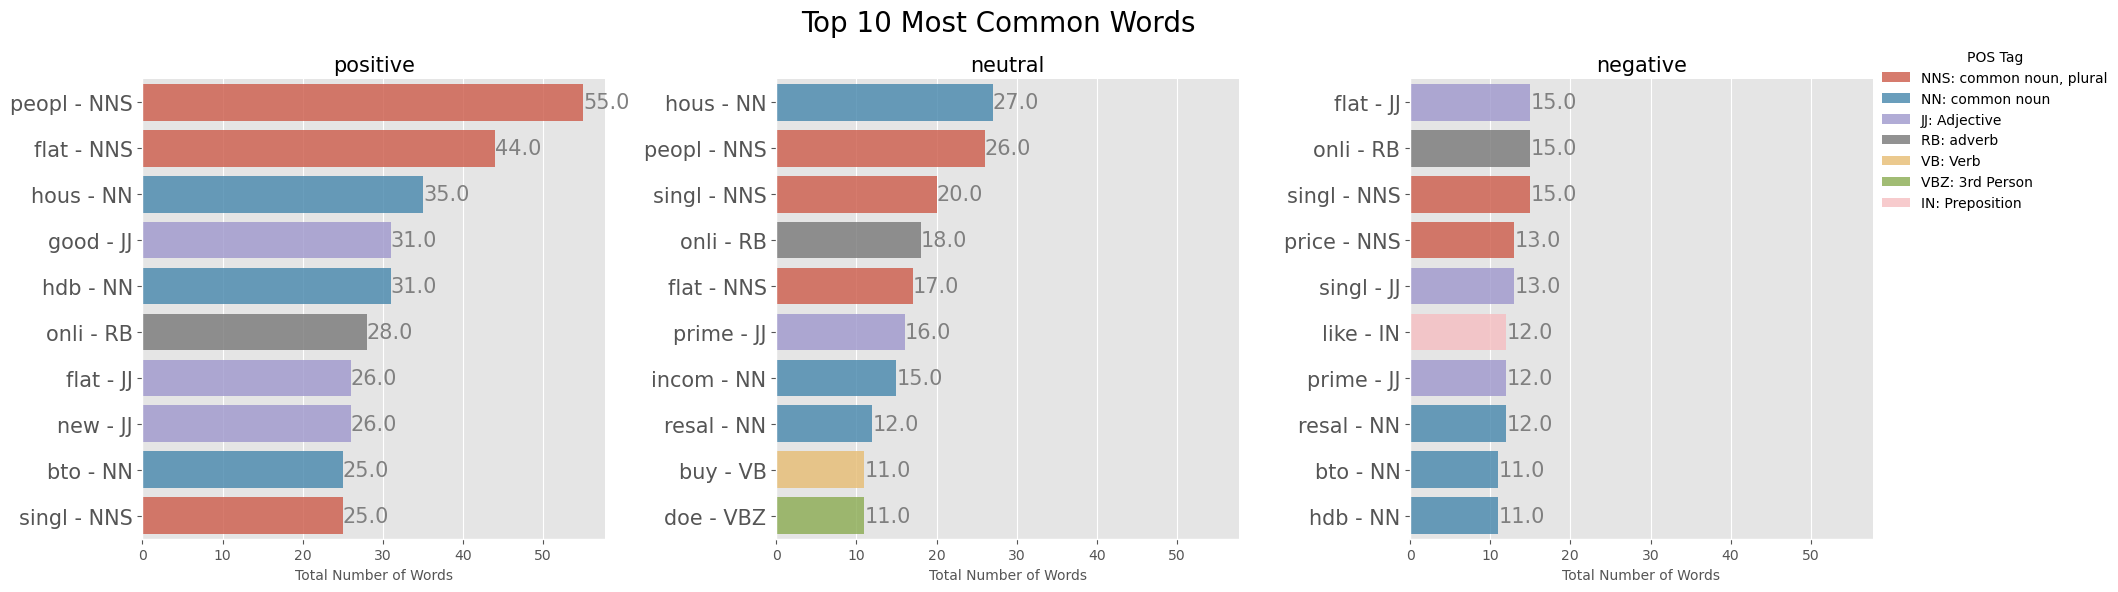

In [65]:
g = sns.catplot(data = df_nlp_15,
            x = "total_number", y = "comment_1_2",
            kind = "bar",
            hue = "comment_2",
            col = "sentiment",
            dodge = False,
            sharey = False,
            alpha = 0.8, height = 6, aspect = 1)

for ax in g.axes.ravel():
    for c in ax.containers:
        labels = [f'{v.get_width()}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', color = "grey", size = 15)

title = ["positive", "neutral", "negative"]

axes = g.axes.flatten()

for i in range(3):
    axes[i].set_title(title[i], size = 15)
    l = axes[i].get_yticklabels()
    axes[i].set_yticklabels(l, fontsize=15)
    axes[i].set_ylabel("")
    axes[i].set_xlabel("Total Number of Words", size = 10)

new_title = 'POS Tag'
g._legend.set_title(new_title)

new_labels = ['NNS: common noun, plural', 'NN: common noun', 'JJ: Adjective', 'RB: adverb', 'VB: Verb', 'VBZ: 3rd Person', 'IN: Preposition']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

g._legend.set_bbox_to_anchor((1.12, 0.77))

plt.suptitle("Top 10 Most Common Words", size = 20, x = 0.53)

plt.tight_layout()
plt.show()
